In [1]:
import uproot
import hist
from hist import Hist
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
from scipy.optimize import curve_fit

In [2]:
f_mumu = uproot.open("/work/submit/jaeyserm/fccee/FCCAnalyzer/afb.root")
print(f_mumu.keys())

['wzp6_ee_mumu_ecm91p2;1', 'wzp6_ee_mumu_ecm91p2/gen_muons_p;1', 'wzp6_ee_mumu_ecm91p2/gen_muons_theta;1', 'wzp6_ee_mumu_ecm91p2/gen_muons_phi;1', 'wzp6_ee_mumu_ecm91p2/gen_muons_no;1', 'wzp6_ee_mumu_ecm91p2/evts_initial;1', 'wzp6_ee_mumu_ecm91p2/leps_all_gen_p;1', 'wzp6_ee_mumu_ecm91p2/leps_all_p;1', 'wzp6_ee_mumu_ecm91p2/leps_all_theta;1', 'wzp6_ee_mumu_ecm91p2/leps_all_phi;1', 'wzp6_ee_mumu_ecm91p2/leps_all_q;1', 'wzp6_ee_mumu_ecm91p2/leps_all_no;1', 'wzp6_ee_mumu_ecm91p2/m_inv;1', 'wzp6_ee_mumu_ecm91p2/missingEnergy;1', 'wzp6_ee_mumu_ecm91p2/visibleEnergy;1', 'wzp6_ee_mumu_ecm91p2/theta_plus;1', 'wzp6_ee_mumu_ecm91p2/theta_minus;1', 'wzp6_ee_mumu_ecm91p2/cos_theta_plus;1', 'wzp6_ee_mumu_ecm91p2/cos_theta_minus;1', 'wzp6_ee_mumu_ecm91p2/cosThetac;1', 'wzp6_ee_mumu_ecm91p2/evts_final;1', 'wzp6_ee_mumu_ecm91p2/meta;1', 'kkmc_ee_mumu_ecm91p2;1', 'kkmc_ee_mumu_ecm91p2/gen_muons_p;1', 'kkmc_ee_mumu_ecm91p2/gen_muons_theta;1', 'kkmc_ee_mumu_ecm91p2/gen_muons_phi;1', 'kkmc_ee_mumu_ecm91p2/

The histograms are saved as `process_name/histogram_name`. We have two processes here corresponding to two different generators (Whizard and KKMC) that produces events of Z->mumu. Let's plot the cos(theta_c) distribution for both generators:

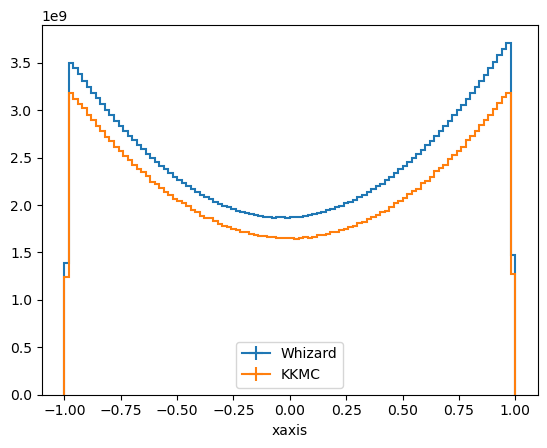

In [3]:
costhetac_whizard = f_mumu['wzp6_ee_mumu_ecm91p2/cosThetac'].to_hist()
costhetac_kkmc = f_mumu['kkmc_ee_mumu_ecm91p2/cosThetac'].to_hist()
hep.histplot([costhetac_whizard, costhetac_kkmc], label=[r'Whizard', 'KKMC'])
plt.legend()

Clearly there is a difference between both generators, KKMC being more accurate as it takes into account higher order calculations that directly affect the forward-backward asymmetry and therefore the cos(theta_c) distribution. The forward-backward asymmetry is defined as (N_F-N_B)/(N_F+N_B), with N_F(B) the amount of events in the foward(backward) region. Let's write a quick function to calculate the A_FB so we can use it for both generators:

In [4]:
def calculate_afb(h):
    N_B = h[-1j:0j].sum().value
    N_F = h[0j:1j].sum().value
    A_FB = (N_F-N_B)/(N_F+N_B)
    A_FB_err = (4*N_F*N_B/(N_F+N_B)**3)**0.5 # statistical error
    return A_FB, A_FB_err

afb_whizard, afb_err_whizard = calculate_afb(costhetac_whizard)
afb_kkmc, afb_err_kkmc = calculate_afb(costhetac_kkmc)
print("afb_whizard", afb_whizard, "error", afb_err_whizard)
print("afb_kkmc", afb_kkmc, "error", afb_err_kkmc)

afb_whizard 0.022094646559258458 error 2.022591124853442e-06
afb_kkmc 0.0007090118797215973 error 2.154476575188632e-06


Another way to calculate the forward-backward is by fitting the cos(theta_c) distribution to a quadratic function (the afb is the parameter b in the fit function):

afb_whizard 0.022285645675881826 error 1.988441822378523e-06
afb_kkmc 0.000665434443487579 error 2.1192322101364398e-06


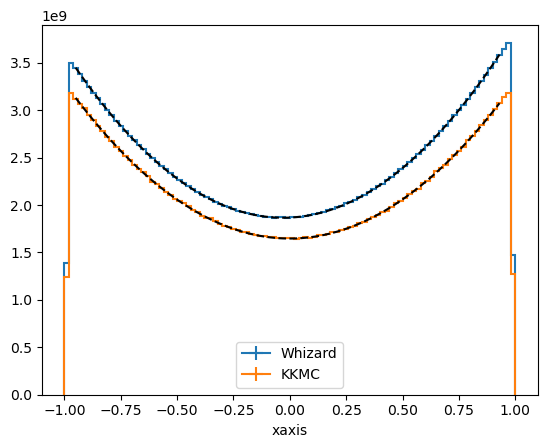

In [5]:
def fit_afb(h, xMin=-0.95, xMax=0.95):
    def func(x, a, b):
        return a*(3.*(1.+x*x)/8. + b*x)
    h_sliced = h[complex(0,xMin):complex(0,xMax)] # select range to fit
    xdata = h_sliced.axes[0].centers
    ydata = h_sliced.values()
    sigma = np.sqrt(h_sliced.values()) # take the sqrt(N) as Poisson uncertainty
    popt, pcov = curve_fit(func, xdata, ydata, p0=[1e9, 0], sigma=sigma, absolute_sigma=True)
    A_FB = popt[1]
    A_FB_err = pcov[1][1]**0.5
    ydata_fit = func(xdata, *popt)
    return A_FB, A_FB_err, xdata, ydata_fit

afb_whizard, afb_err_whizard, x_whizard, y_whizard = fit_afb(costhetac_whizard)
afb_kkmc, afb_err_kkmc, x_kkmc, y_kkmc = fit_afb(costhetac_kkmc)
print("afb_whizard", afb_whizard, "error", afb_err_whizard)
print("afb_kkmc", afb_kkmc, "error", afb_err_kkmc)

costhetac_whizard = f_mumu['wzp6_ee_mumu_ecm91p2/cosThetac'].to_hist()
costhetac_kkmc = f_mumu['kkmc_ee_mumu_ecm91p2/cosThetac'].to_hist()
hep.histplot([costhetac_whizard, costhetac_kkmc], label=[r'Whizard', 'KKMC'])
plt.plot(x_whizard, y_whizard, '--', color='black')
plt.plot(x_kkmc, y_kkmc, '--', color='black')
plt.legend()